# Hello, Conv2D MNIST!

In this notebook, we'll train a convolutional neural network on MNIST using the newly defined Conv2D class.

First, let's download the MNIST data.

In [1]:
import sys
import os

# Add examples directory to path to access data module
examples_path = os.path.abspath(os.path.join(os.getcwd(), '..', 'examples'))
sys.path.insert(0, examples_path)

from data.mnist import load_mnist

# Load the MNIST dataset
train_images, train_labels, test_images, test_labels = load_mnist()

# Print shapes to verify loading
print(f"Training images shape: {train_images.shape}")
print(f"Training labels shape: {train_labels.shape}")
print(f"Test images shape: {test_images.shape}")
print(f"Test labels shape: {test_labels.shape}")

Training images shape: (60000, 28, 28)
Training labels shape: (60000,)
Test images shape: (10000, 28, 28)
Test labels shape: (10000,)


Let's visualize a few training samples.

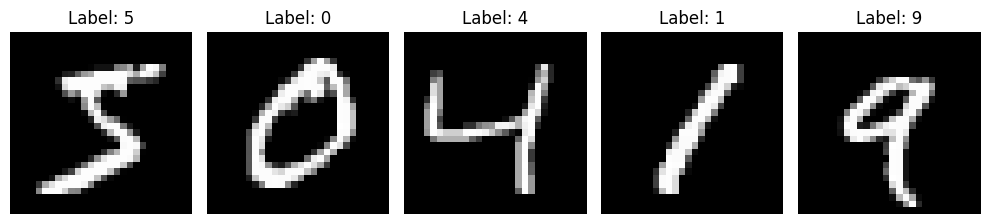

In [2]:
import matplotlib.pyplot as plt

# Create a figure with 5 subplots
fig, axes = plt.subplots(1, 5, figsize=(10, 3))

# Plot each image and its label
for i in range(5):
    axes[i].imshow(train_images[i], cmap='gray')
    axes[i].set_title(f'Label: {train_labels[i]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

Now we need to prepare the data for Conv2D. Unlike the MLP which uses flattened inputs, Conv2D expects images in [N, H, W, C] format. We'll also encode targets as one-hot vectors and write a mini-batch sampler.

In [3]:
import jax
import jax.numpy as jnp

def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

# Reshape images to [N, H, W, C] format (add channel dimension)
X_train = train_images[..., None]  # shape: [60000, 28, 28, 1]
y_train = one_hot(train_labels, 10)

X_test = test_images[..., None]  # shape: [10000, 28, 28, 1]

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Get a batch
def get_batch(key, batch_size):
    idx = jax.random.choice(key, X_train.shape[0], shape=(batch_size,))
    return X_train[idx], y_train[idx]

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)


Now let's build a CNN using the Conv2D class. We'll use a simple architecture:
- Conv2D: 1 → 16 channels, 3x3 kernel
- ReLU
- Conv2D: 16 → 32 channels, 3x3 kernel  
- ReLU
- Flatten the spatial dimensions
- Linear layer to output (10 classes)

In [ ]:
import sys
import os

# Add the project root to the Python path to access modula module
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from modula.atom import Conv2D, Linear
from modula.bond import ReLU, Flatten

# Build the CNN
# Input: [N, 28, 28, 1]
# After conv1: [N, 28, 28, 16] (SAME padding)
# After conv2: [N, 28, 28, 32]
# After flatten: [N, 28*28*32] = [N, 25088]
# After linear: [N, 10]

d_in = 1
d_hidden1 = 16
d_hidden2 = 32
kernel_size = 3
output_dim = 10
flattened_dim = 28 * 28 * d_hidden2  # 25088

cnn = Linear(output_dim, flattened_dim)
cnn @= Flatten()
cnn @= ReLU() @ Conv2D(d_hidden1, d_hidden2, kernel_size)
cnn @= ReLU() @ Conv2D(d_in, d_hidden1, kernel_size)

print(cnn)

cnn.jit()

CompositeModule
...consists of 3 atoms and 3 bonds
...non-smooth
...input sensitivity is 1
...contributes proportion 3 to feature learning of any supermodule


Let's train the CNN for 1000 steps.

In [6]:
from tqdm.notebook import tqdm

def mse(w, inputs, targets):
    outputs = cnn(inputs, w)
    loss = ((outputs - targets) ** 2).mean()
    return loss

mse_and_grad = jax.jit(jax.value_and_grad(mse))

batch_size = 128
steps = 1000
learning_rate = 0.1

key = jax.random.PRNGKey(0)
w = cnn.initialize(key)
    
progress_bar = tqdm(range(steps), desc=f"Loss: {0:.4f}")
for step in progress_bar:
    key = jax.random.PRNGKey(step)
    inputs, targets = get_batch(key, batch_size)
    
    loss, grad_w = mse_and_grad(w, inputs, targets)
    d_w = cnn.dualize(grad_w)
    w = [weight - learning_rate * d_weight for weight, d_weight in zip(w, d_w)]
    progress_bar.set_description(f"Loss: {loss:.4f}")

Loss: 0.0000:   0%|          | 0/1000 [00:00<?, ?it/s]

Finally, let's evaluate the model on test data and visualize some predictions.

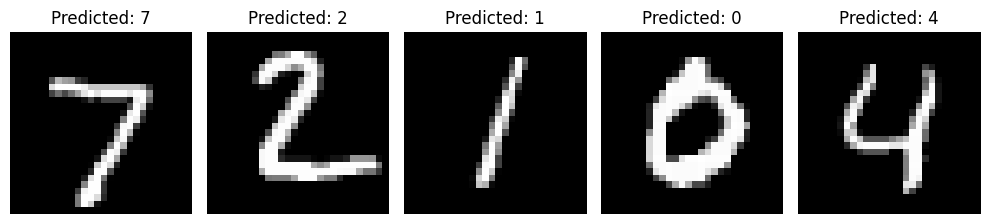

Accuracy on shown samples: 5/5
Overall test accuracy: 97.24%


In [7]:
# Get predictions for test images
test_outputs = cnn(X_test, w)
predicted_labels = jnp.argmax(test_outputs, axis=1)

# Create a figure with subplots for multiple test images
n_samples = 5  # Number of test images to display
fig, axes = plt.subplots(1, n_samples, figsize=(10, 3))

# Plot each test image with predicted labels
for i in range(n_samples):
    axes[i].imshow(test_images[i], cmap='gray')
    axes[i].set_title(f'Predicted: {int(predicted_labels[i])}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Print accuracy for these samples
correct = (predicted_labels[:n_samples] == test_labels[:n_samples]).sum()
print(f"Accuracy on shown samples: {correct}/{n_samples}")

# Calculate and print overall test accuracy
total_correct = (predicted_labels == test_labels).sum()
total_samples = len(test_labels)
print(f"Overall test accuracy: {100 * total_correct/total_samples:.2f}%")